# Generating Realistic Negative Financial Returns

This notebooks contains the implementative details of the project. 

**Summary:** This work aims at studying generative models that are capable of reproducing realistic data of negative log-returns of financial investments. The data used for training contains 746 four-dimensional observations. Each row refers to a simultaneous adverse loss of 4 different financial assets, but they are not in chronological order. The goal is to be able to replicate the magnitude of the losses, not to predict the time of their occurence. For an easier visualization, we changed the sign of the data to positive values. 
This is an unsupervised learning problem, and the criteria for evaluating a good performance are nontrivial. We will use the Anderson Darling distance (or AD distance) as a measure of accuracy of the tail estimation of the models and the Absolute Kendall Error (or AKE) to measure the correlation structure of the four features.
We propose two models: a Wasserstein-GAN, which has been succesfully employed in different tasks, and a simple but effective model based on an empirical Energy Distance between distributions.


See *Generative_Models.pdf* for details on the theory behind the models implemented and the explanation of the two metrics used to evaluate the model.

**Remark:** We will only use the Gaussian distribution as latent space distribution. We attempted at using some more heavy-tailed ditribution (exponential, t-Student, ...) but none of them performed better (despite some articles form the literature of estimating extreme values suggesting otherwise).

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from w_gan import WGAN
from edm import EDM
from data_utils import *
from grid_searches import *
from visuals import *

seed = 42
np.random.seed(seed)

### Loading the Data

We split the data into training and testing data. To ensure a fair testing, we split proportionally the observations where at least one of the tickers is above the 90% quantile of that marginal distribution.

In [10]:
data_path = "data/data_log_return.csv"
training_path = 'data/val/train_data.csv'
validation_path = 'data/val/val_data.csv'
testing_path = 'data/test_data.csv'
training_and_val_path = 'data/train_data.csv'

load_data_balanced(
    data_path, training_and_val_path, testing_path
)

We further split training data into training and validation data.

In [11]:
load_data_balanced(
    training_and_val_path, training_path, validation_path
)

### A quick EDA

In order to have a feel of what the data looks like, let us plot have a look at summary statistics and plot some histograms of the marginals.

In [12]:
data = pd.read_csv(data_path, names=["idx", "X1", "X2", "X3", "X4"], header=0)
data = data.set_index(["idx"])
data.describe()

,X1,X2,X3,X4
count,745.000000,745.000000,745.000000,745.000000
mean,0.013145,0.012824,0.009374,0.010794
std,0.011922,0.011720,0.009287,0.009343
min,0.000012,0.000057,0.000014,0.000067
25%,0.004759,0.003876,0.003196,0.004219
50%,0.010025,0.009421,0.006642,0.008522
75%,0.017825,0.017813,0.012364,0.014229
max,0.098709,0.088502,0.072016,0.074291


Correlations are quite high, as expected. Replicating the correct correlation structure will be crucial.

In [13]:
corr = data.corr()
corr

,X1,X2,X3,X4
X1,1.000000,0.491825,0.434015,0.659544
X2,0.491825,1.000000,0.653692,0.450167
X3,0.434015,0.653692,1.000000,0.475379
X4,0.659544,0.450167,0.475379,1.000000


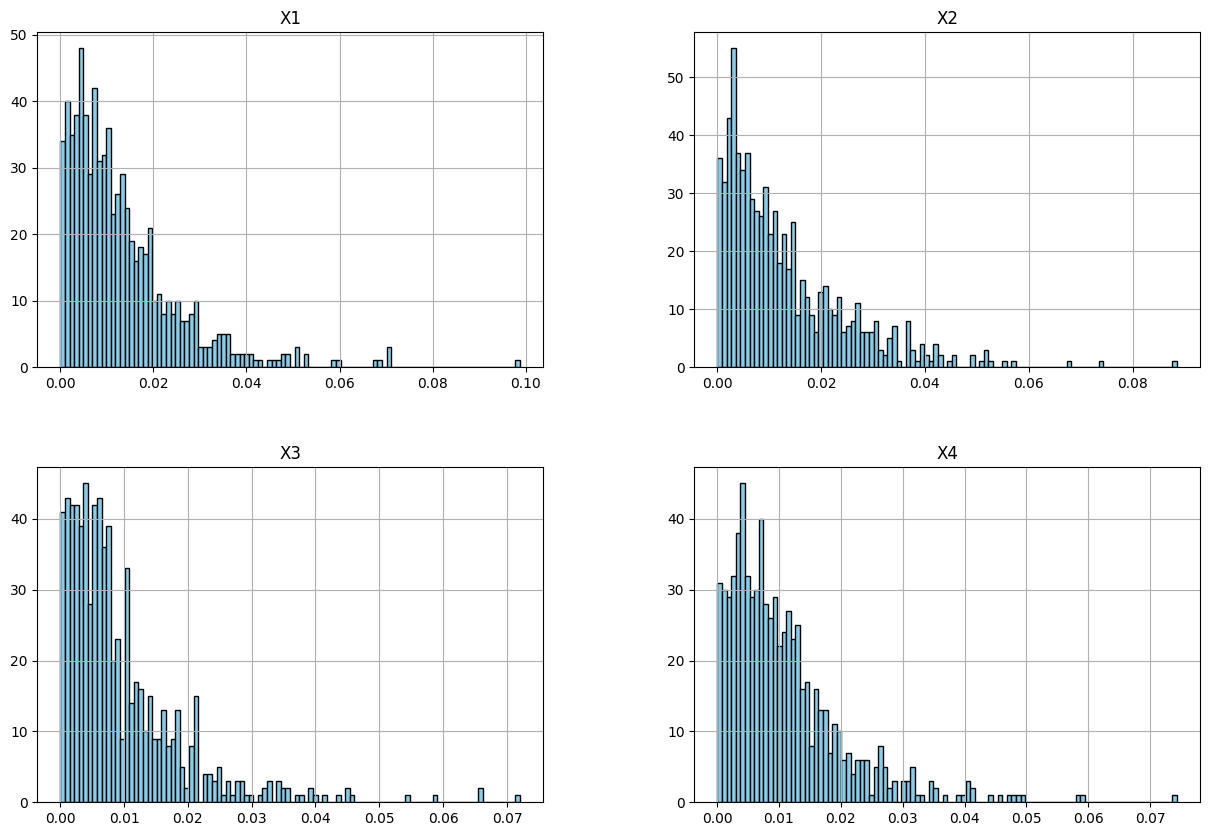

In [14]:
data.hist(bins=100, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.show()

### Wasserstein GAN
W-GAN is a more robust version of the standard GAN, with a critic estimating a probability of true/fake sample instead of a discriminator performing binary classification.
As a result, it's less prone to mode-collapse and does not add complexity in the implementation.

We attempted at some forms of early stopping. At first, we tried criteria based on the two metrics we will use to test the model: we run batches for an epoch, and generate data with the model at the end of the epoch. We compare it with the validation set, computing AD distance and AKE between the validation set and the generated data. If for a set number of epochs we do not observe an improvement in either metric/both metrics, we stop the training. It was not possible to define a single objective metric from the two, seeing as their scales are completely different and show an unclear dependence on the generated sample size.
This approach was unsuccesful, since we observed little regularity in AD distance and AKE during training and a tendency of these quantities to spike for a considerable number of epochs before improving.
We also provide an early stopping technique that relies on the energy distance between the generated data and the validation data. It doesn't seem to be too reliable either.

We opted for a grid search approach using the number of epochs as a hyperparameter to tune. At the end of training, the quality of a model is verified by generating data and computing AD distance and AKE with the validation data. To reduce computational costs, for each combination of the other hyperparameters we train only the model with the maximum number of epochs and simply store "checkpoint values" of AD distance and AKE every 500 epochs during training. 

A more sound approach would be using cross validation. We provide an implementation, but WGAN is relatively costly from a computational point of view (for my machine), so we perform a grid search only. We still provide an example of usage of the cross validation method provided by the class WGAN. In the CV we implemented, the summary metrics used to evaluate the best set of parameters are the across-fold average of (very) late-start averages of AD distance and AKE computed in the last few epochs between generated data and the validation fold. The goal of the late-starting is to reduce a the variance of the metric, making it more reliable.

Below the grid search implementation and the CV for the most promising models. Choices of epochs, network structures and range are partially led by some preliminary runs and qualitative assessments using Tensorboard and plotting the metrics of interest and some other more qualitative plots (like that of empirical CDFs, discussed in the last section) and some previous grid searches.
We actually considered latent dimensions from 4 to 64, networks form 16 to 256, other learning rates, ...

In [37]:
run_next_cell = True

In [ ]:
par_dict = {
    "latent_dim" : [8, 16, 32],
    "g_hidden_dim" : [64, 128, 256],
    "lr" : [0.0001], 
    "d_hidden_dim": [64, 128, 256]
}

if run_next_cell:
    grid_search_wgan(training_path, validation_path, par_dict, epochs=5000, every=500, path="results/grid_wgan.csv")

Let's look at the best combinations. Priority should go to AD distance to ensure a good estimation of the tails.

In [34]:
grid_results = pd.read_csv("results/grid_wgan.csv")
grid_results = grid_results.sort_values(by=["AKE", "AD"], ascending=True)
grid_results["idx_ake_sorting"] = range(1, len(grid_results) + 1)
grid_results = grid_results.sort_values(by=["AD", "AKE"], ascending=True)
grid_results["idx_ad_sorting"] = range(1, len(grid_results) + 1)
grid_results.drop("Unnamed: 0", axis=1, inplace=True)
grid_results.head(8)

,latent_dim,g_hidden_dim,lr,d_hidden_dim,AD,AKE,epochs,idx_ake_sorting,idx_ad_sorting
15,8,64,0.0001,128,0.949741,0.012535,3000,8,1
145,16,128,0.0001,256,1.299164,0.040266,3000,203,2
17,8,64,0.0001,128,1.314535,0.027661,4000,124,3
95,16,64,0.0001,64,1.401852,0.032983,3000,158,4
207,32,64,0.0001,256,1.484412,0.044608,4000,223,5
74,8,256,0.0001,128,1.525499,0.031863,2500,155,6
225,32,128,0.0001,128,1.640841,0.058123,3000,258,7
156,16,256,0.0001,64,1.641631,0.030462,3500,143,8


In [35]:
best_params_wgan = {    
    "latent_dim" : 8,
    "g_hidden_dim" : 64,
    "lr" : 0.0001, 
    "d_hidden_dim": 128
}
best_wgan_epochs = 3000

The commented cells below are some "extras" that may be of interest: the first two cells are for the cross validation method in WGAN, the other two are for viewing the history of AD distance and AK error compared to validation data during training.

In [21]:
# run_next_cell = False

In [40]:
# if run_next_cell:
#     wgan = WGAN(**best_params_wgan)
#     ad_avg, ake_avg = wgan.cross_val(training_and_val_path, epochs = 100)
#     print("AD: ", np.mean(ad_avg), " AKE: ", np.mean(ake_avg))

In [ ]:
# run_next_cell = False

In [ ]:
# run_next_cell = False
# if run_next_cell:
#     wgan = WGAN(**best_params_wgan)
#     ads, akes, epochs = wgan.train_with_history(training_path, epochs=3000, val_path = validation_path)

#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(epochs, ads)
#     plt.title("AD Distance")
#     plt.xlabel("Epochs")
#     plt.ylabel("AD Distance")
    
#     plt.subplot(1, 2, 2)
#     plt.plot(epochs, akes)
#     plt.title("AK Error")
#     plt.xlabel("Epochs")
#     plt.ylabel("AK Error")
#     plt.show()


### Energy Distance Model

This model is simpler and more unusual. However, it appears to be quite accurate and has considerable advantages in terms of computational costs.
Since the loss is simply the energy distance between generated data and real data, we can naturally add an early stopping criterion using the eergy distance between generated data and validation data at the end of each epoch. Similarly to WGAN, it was unsuccesful to apply a early stopping criterion based on AD distance and AKE.

We perform a grid search for hyperparameter tuning.

In [23]:
par_dict = {
    "latent_dim" : [8, 16, 32],
    "g_hidden_dim" : [64, 128, 256],
    "lr" : [0.0001], 
}

grid_search_edm(training_path, validation_path, par_dict, epochs=5000, path="results/grid_edm.csv", patience=250)

device cpu
Loading EDM...
Model loaded.
EDM, number: 1, parameters: {'latent_dim': 8, 'g_hidden_dim': 64, 'lr': 0.0001}
[[0.01926839 0.03053748 0.00475431 0.00509221]
 [0.02234986 0.04169054 0.02146301 0.0127719 ]
 [0.01250907 0.01217865 0.00170516 0.03561171]
 ...
 [0.00827132 0.00347306 0.00997516 0.00776511]
 [0.00362006 0.00657798 0.00569379 0.01124262]
 [0.00546408 0.01267722 0.00825719 0.00415724]]


c:\Users\feder\OneDrive\Immagini\Documenti\GitHub\Generating_Realistic_Financial_Losses\grid_searches.py:93: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row])


Early stopping at epoch 622.
Training done
Best loss: 0.00015052221715450287, Best epoch: 372, AD distance: 1.3716321316175595, AKE error: 0.013375350140056023
device cpu
Loading EDM...
Model loaded.
EDM, number: 2, parameters: {'latent_dim': 8, 'g_hidden_dim': 128, 'lr': 0.0001}
[[0.01926839 0.03053748 0.00475431 0.00509221]
 [0.02234986 0.04169054 0.02146301 0.0127719 ]
 [0.01250907 0.01217865 0.00170516 0.03561171]
 ...
 [0.00827132 0.00347306 0.00997516 0.00776511]
 [0.00362006 0.00657798 0.00569379 0.01124262]
 [0.00546408 0.01267722 0.00825719 0.00415724]]


Early stopping at epoch 656.
Training done
Best loss: 0.00015518628060817719, Best epoch: 406, AD distance: 1.1958687715674685, AKE error: 0.01946778711484594
device cpu
Loading EDM...
Model loaded.
EDM, number: 3, parameters: {'latent_dim': 8, 'g_hidden_dim': 256, 'lr': 0.0001}
[[0.01926839 0.03053748 0.00475431 0.00509221]
 [0.02234986 0.04169054 0.02146301 0.0127719 ]
 [0.01250907 0.01217865 0.00170516 0.03561171]
 ...
 [0.00827132 0.00347306 0.00997516 0.00776511]
 [0.00362006 0.00657798 0.00569379 0.01124262]
 [0.00546408 0.01267722 0.00825719 0.00415724]]


Early stopping at epoch 611.
Training done
Best loss: 0.00014687702059745789, Best epoch: 361, AD distance: 1.3059511141775246, AKE error: 0.01876750700280112
device cpu
Loading EDM...
Model loaded.
EDM, number: 4, parameters: {'latent_dim': 16, 'g_hidden_dim': 64, 'lr': 0.0001}
[[0.01926839 0.03053748 0.00475431 0.00509221]
 [0.02234986 0.04169054 0.02146301 0.0127719 ]
 [0.01250907 0.01217865 0.00170516 0.03561171]
 ...
 [0.00827132 0.00347306 0.00997516 0.00776511]
 [0.00362006 0.00657798 0.00569379 0.01124262]
 [0.00546408 0.01267722 0.00825719 0.00415724]]


Early stopping at epoch 802.
Training done
Best loss: 0.0001376364380121231, Best epoch: 552, AD distance: 1.193680253985896, AKE error: 0.020378151260504202
device cpu
Loading EDM...
Model loaded.
EDM, number: 5, parameters: {'latent_dim': 16, 'g_hidden_dim': 128, 'lr': 0.0001}
[[0.01926839 0.03053748 0.00475431 0.00509221]
 [0.02234986 0.04169054 0.02146301 0.0127719 ]
 [0.01250907 0.01217865 0.00170516 0.03561171]
 ...
 [0.00827132 0.00347306 0.00997516 0.00776511]
 [0.00362006 0.00657798 0.00569379 0.01124262]
 [0.00546408 0.01267722 0.00825719 0.00415724]]


Early stopping at epoch 743.
Training done
Best loss: 0.00014358200132846832, Best epoch: 493, AD distance: 1.085176045707314, AKE error: 0.024019607843137256
device cpu
Loading EDM...
Model loaded.
EDM, number: 6, parameters: {'latent_dim': 16, 'g_hidden_dim': 256, 'lr': 0.0001}
[[0.01926839 0.03053748 0.00475431 0.00509221]
 [0.02234986 0.04169054 0.02146301 0.0127719 ]
 [0.01250907 0.01217865 0.00170516 0.03561171]
 ...
 [0.00827132 0.00347306 0.00997516 0.00776511]
 [0.00362006 0.00657798 0.00569379 0.01124262]
 [0.00546408 0.01267722 0.00825719 0.00415724]]


Early stopping at epoch 499.
Training done
Best loss: 0.00016678869724273682, Best epoch: 249, AD distance: 1.571956003060052, AKE error: 0.026190476190476188
device cpu
Loading EDM...
Model loaded.
EDM, number: 7, parameters: {'latent_dim': 32, 'g_hidden_dim': 64, 'lr': 0.0001}
[[0.01926839 0.03053748 0.00475431 0.00509221]
 [0.02234986 0.04169054 0.02146301 0.0127719 ]
 [0.01250907 0.01217865 0.00170516 0.03561171]
 ...
 [0.00827132 0.00347306 0.00997516 0.00776511]
 [0.00362006 0.00657798 0.00569379 0.01124262]
 [0.00546408 0.01267722 0.00825719 0.00415724]]


Early stopping at epoch 700.
Training done
Best loss: 0.00013357773423194885, Best epoch: 450, AD distance: 0.968937422547608, AKE error: 0.018137254901960786
device cpu
Loading EDM...
Model loaded.
EDM, number: 8, parameters: {'latent_dim': 32, 'g_hidden_dim': 128, 'lr': 0.0001}
[[0.01926839 0.03053748 0.00475431 0.00509221]
 [0.02234986 0.04169054 0.02146301 0.0127719 ]
 [0.01250907 0.01217865 0.00170516 0.03561171]
 ...
 [0.00827132 0.00347306 0.00997516 0.00776511]
 [0.00362006 0.00657798 0.00569379 0.01124262]
 [0.00546408 0.01267722 0.00825719 0.00415724]]


Early stopping at epoch 624.
Training done
Best loss: 0.00014562718570232391, Best epoch: 374, AD distance: 1.30926438792698, AKE error: 0.014005602240896359
device cpu
Loading EDM...
Model loaded.
EDM, number: 9, parameters: {'latent_dim': 32, 'g_hidden_dim': 256, 'lr': 0.0001}
[[0.01926839 0.03053748 0.00475431 0.00509221]
 [0.02234986 0.04169054 0.02146301 0.0127719 ]
 [0.01250907 0.01217865 0.00170516 0.03561171]
 ...
 [0.00827132 0.00347306 0.00997516 0.00776511]
 [0.00362006 0.00657798 0.00569379 0.01124262]
 [0.00546408 0.01267722 0.00825719 0.00415724]]


Early stopping at epoch 286.
Training done
Best loss: 0.00018912367522716522, Best epoch: 36, AD distance: 1.8451471808804243, AKE error: 0.033263305322128844


,latent_dim,g_hidden_dim,lr,AD,AKE,epochs
0,8,64,0.0001,1.371632,0.013375,372
1,8,128,0.0001,1.195869,0.019468,406
2,8,256,0.0001,1.305951,0.018768,361
3,16,64,0.0001,1.193680,0.020378,552
4,16,128,0.0001,1.085176,0.024020,493
5,16,256,0.0001,1.571956,0.026190,249
6,32,64,0.0001,0.968937,0.018137,450
7,32,128,0.0001,1.309264,0.014006,374
8,32,256,0.0001,1.845147,0.033263,36


In [24]:
grid_results = pd.read_csv("results/grid_edm.csv")
grid_results = grid_results.sort_values(by=["AKE", "AD"], ascending=True)
grid_results["idx_ake_sorting"] = range(1, len(grid_results) + 1)
grid_results = grid_results.sort_values(by=["AD", "AKE"], ascending=True)
grid_results["idx_ad_sorting"] = range(1, len(grid_results) + 1)
grid_results.drop("Unnamed: 0", axis=1, inplace=True)
grid_results.head(8)

,latent_dim,g_hidden_dim,lr,AD,AKE,epochs,idx_ake_sorting,idx_ad_sorting
6,32,64,0.0001,0.968937,0.018137,450,3,1
4,16,128,0.0001,1.085176,0.024020,493,7,2
3,16,64,0.0001,1.193680,0.020378,552,6,3
1,8,128,0.0001,1.195869,0.019468,406,5,4
2,8,256,0.0001,1.305951,0.018768,361,4,5
7,32,128,0.0001,1.309264,0.014006,374,2,6
0,8,64,0.0001,1.371632,0.013375,372,1,7
5,16,256,0.0001,1.571956,0.026190,249,8,8


In [25]:
best_params_edm = {
    "latent_dim" : 32,
    "g_hidden_dim" : 64,
    "lr" : 0.0001
}
best_edm_epochs = 450

### Final training and testing

In [ ]:
run_next_cell = False

In [39]:
if run_next_cell:
    edm = EDM(**best_params_edm)
    wgan = WGAN(**best_params_wgan)

    edm.train(training_and_val_path, epochs=best_edm_epochs)
    wgan.train(training_and_val_path, epochs=best_wgan_epochs, checkpoints=False)

device cpu
Loading EDM...
Model loaded.
device cpu
Loading WGAN...
WGAN loaded.
[[0.06712907 0.08850208 0.0655656  0.07429127]
 [0.012357   0.02064872 0.03600894 0.00884954]
 [0.03003572 0.03935871 0.0275575  0.02336437]
 ...
 [0.00264142 0.00618169 0.00720537 0.00155474]
 [0.01663889 0.01185453 0.0039987  0.00562492]
 [0.00140803 0.02286409 0.00432845 0.00406734]]


Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Training done


100%|██████████| 3000/3000 [04:55<00:00, 10.16it/s]

Training done


We save the models best models

In [43]:
run_nex_cell = False

In [44]:
if run_next_cell:
    edm.save_model()
    wgan.save_model()

For performance assessment and visualization without re-training, we can load the models in the cell below.

In [45]:
edm.load_model()
wgan.load_model()

In [46]:
test_data = pd.read_csv(testing_path, names=["idx", "X1", "X2", "X3", "X4"], header=0)
test_data = test_data.set_index(["idx"])
test_data = test_data.values

edm_ad, edm_ake = edm.evaluate(test_data)
wgan_ad, wgan_ake = wgan.evaluate(test_data)

print("EDM AD: ", edm_ad, " AKE: ", edm_ake)
print("WGAN AD: ", wgan_ad, " AKE: ", wgan_ake)

EDM AD:  1.907249468892111  AKE:  0.029932885906040277
WGAN AD:  4.747284876890326  AKE:  0.04639821029082774


Surprisingly, it seems that the energy distance model performs better on the test data according to both metrics.

To assess them qualitatively, we can also compare the empirical CDFS and the extreme values.

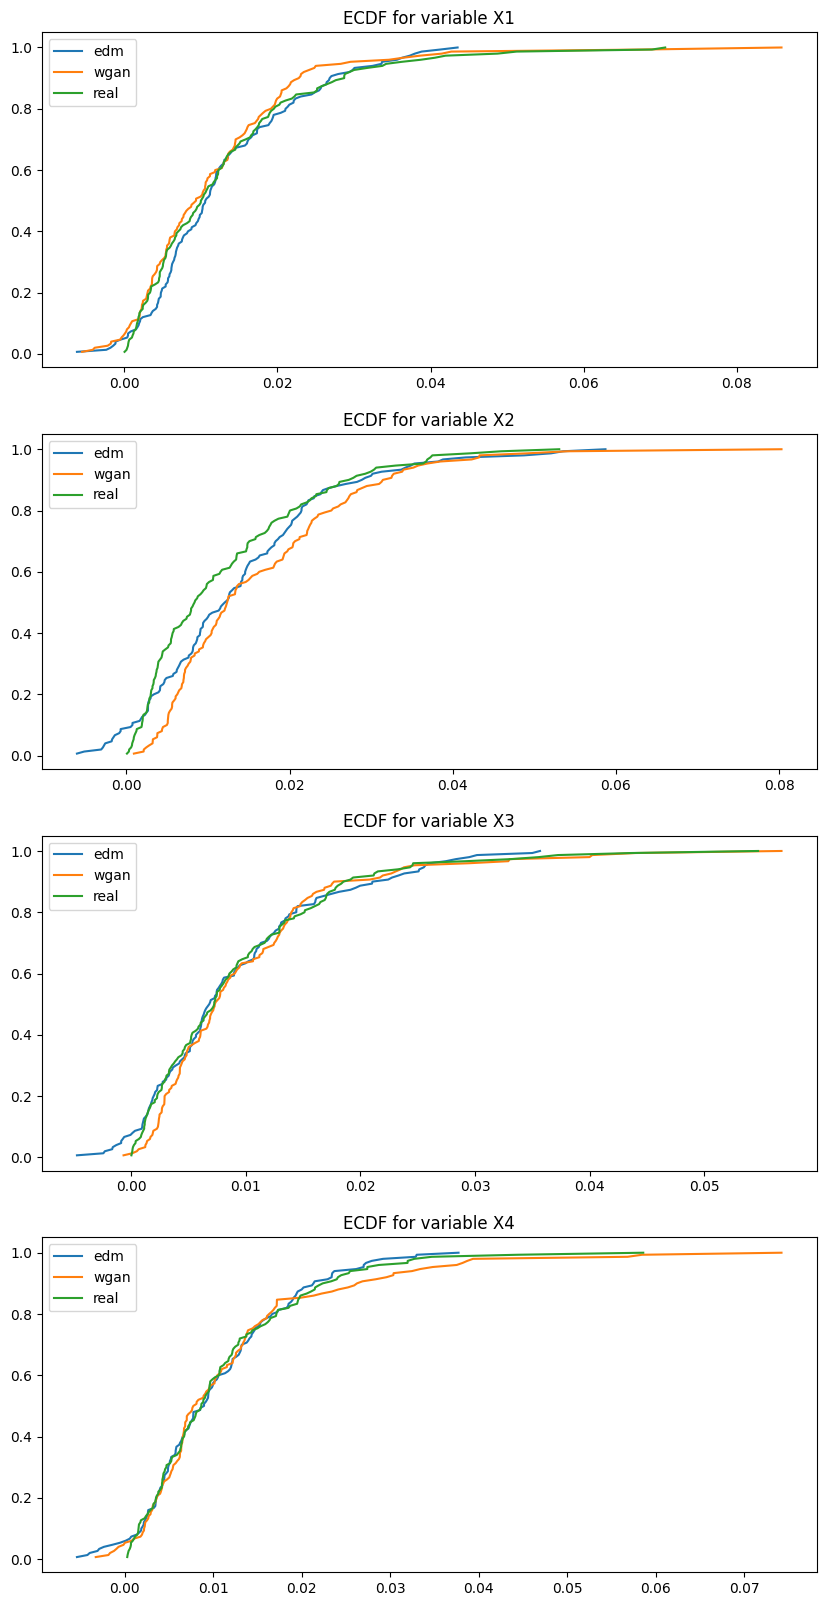

In [47]:
data_edm = edm.generate(test_data.shape[0])
data_wgan = wgan.generate(test_data.shape[0])

plot_ecdfs(data_edm, data_wgan, test_data)

We observe a good resemblance of the empirical CDF of the marginals. Other models we attempted, like standard GAN and VAE, tended to display a completely inaccurate empirical CDF for at least one of the marginals.

It's interesting to notice that the EDM, while accurate, is not really capturing for all variables the whole support for what concerns the rightmost values, and is a bit more "cautious" in generating truly extreme data.

W-GAN, on the other hand, seems to be slightly exceeding the rande of real values.

Now we plot the bidimensional scatterplots and the densities of each feature for the energy model and for W-GAN.

First for EDM:

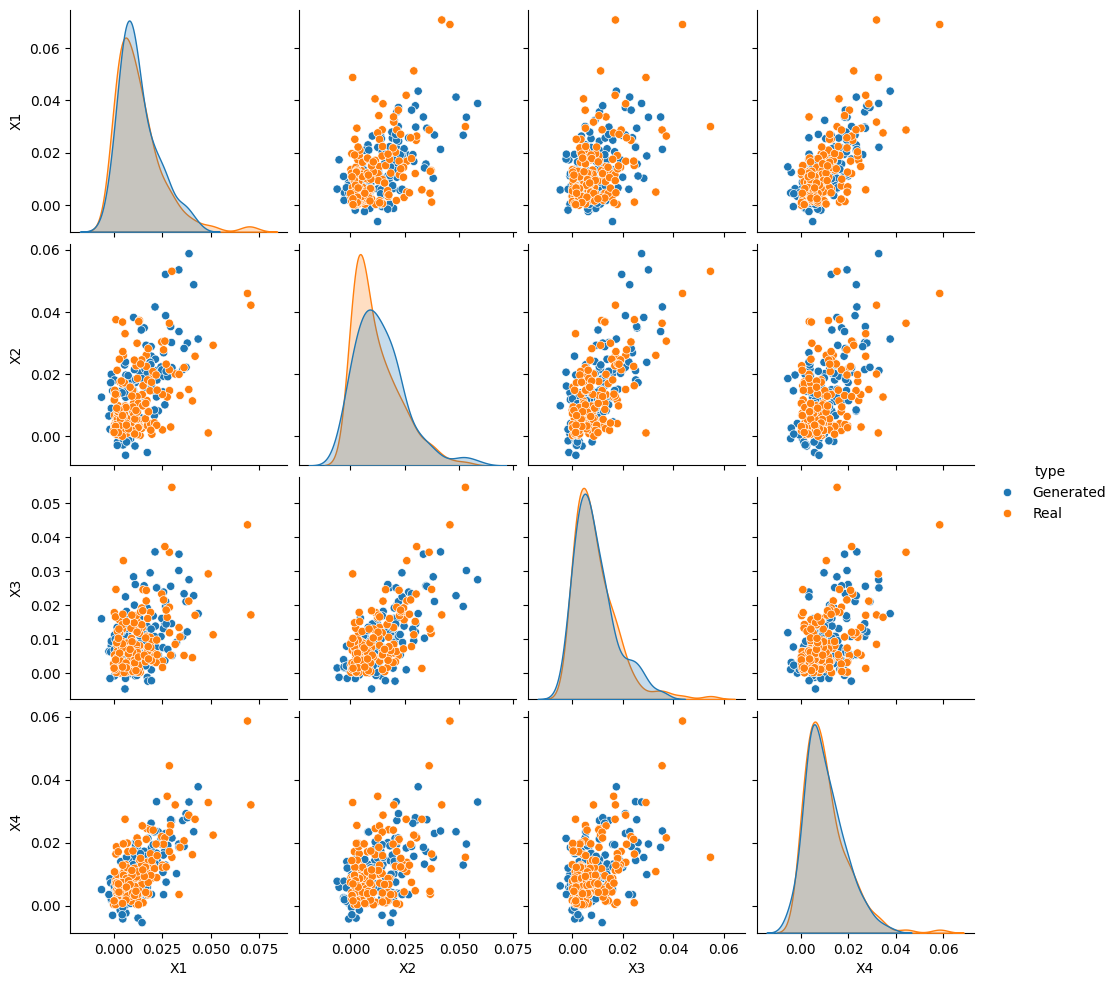

In [49]:
grid_plot(data_edm, test_data)

And for WGAN:

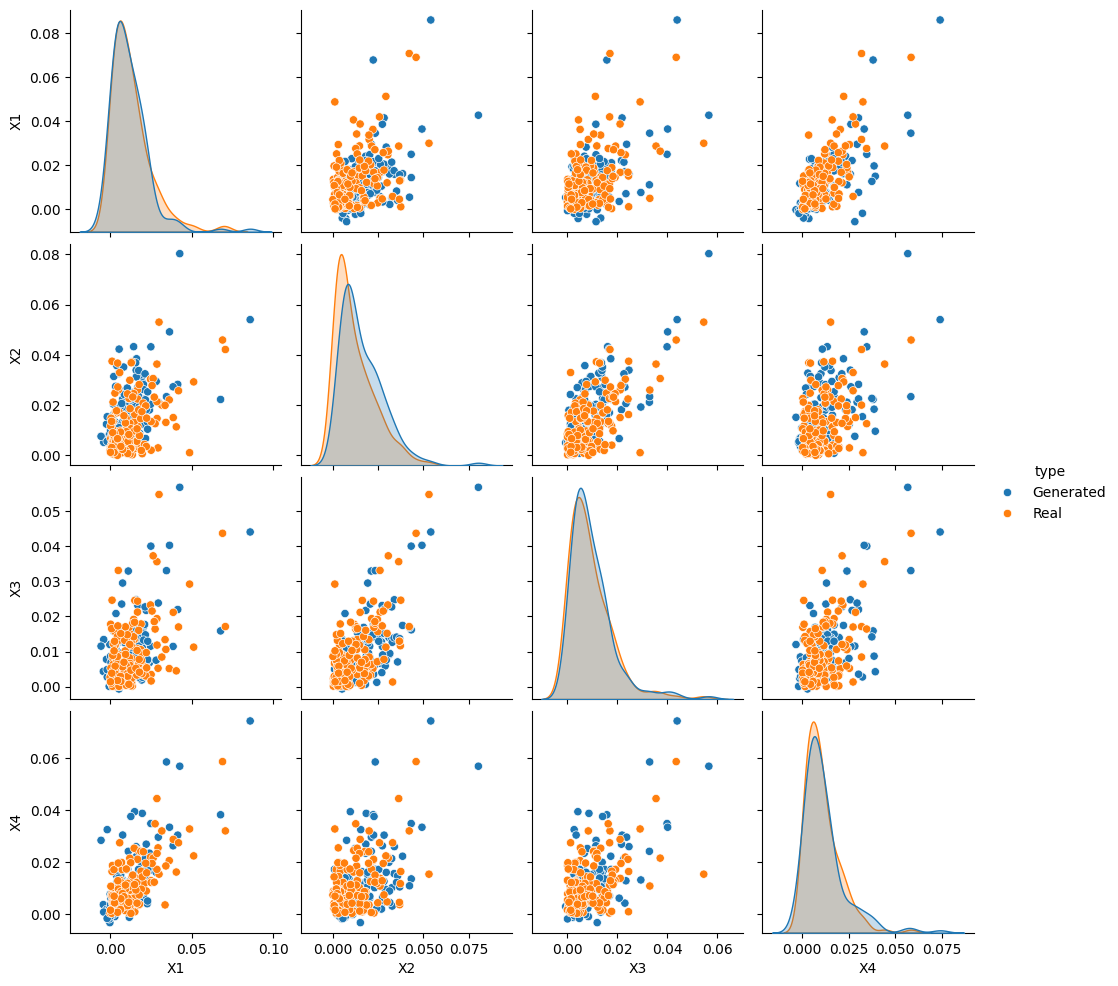

In [50]:
grid_plot(data_wgan, test_data)

They both seem to yield satisfying results, let's focus on the tails of the distributions. 

The following instead display only points for which at least one column displays an "extreme" value (>95 percentile).
This should help us undestand if the models are lacking in estimating extreme values for a particular pair of feature, but the "clouds" do not seem to display unusual behaviours.

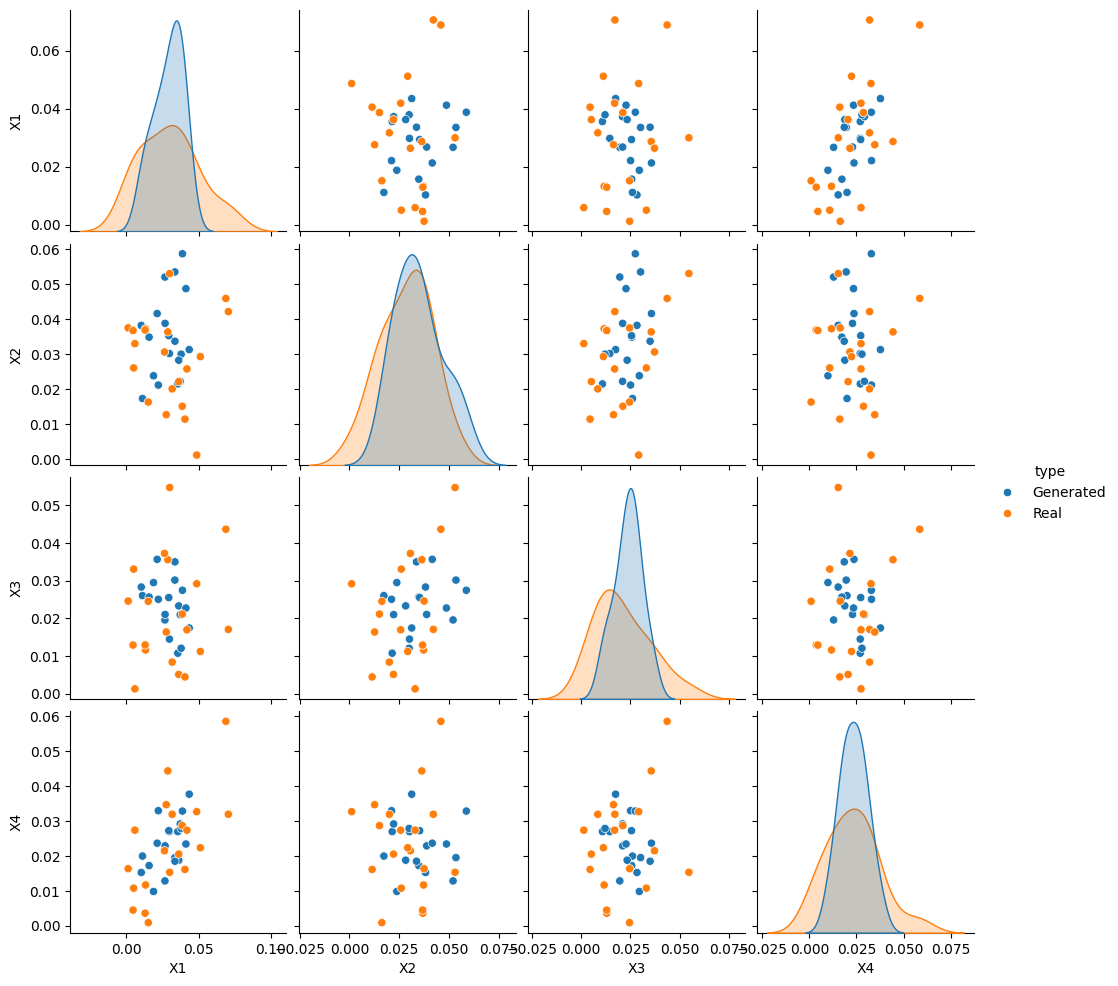

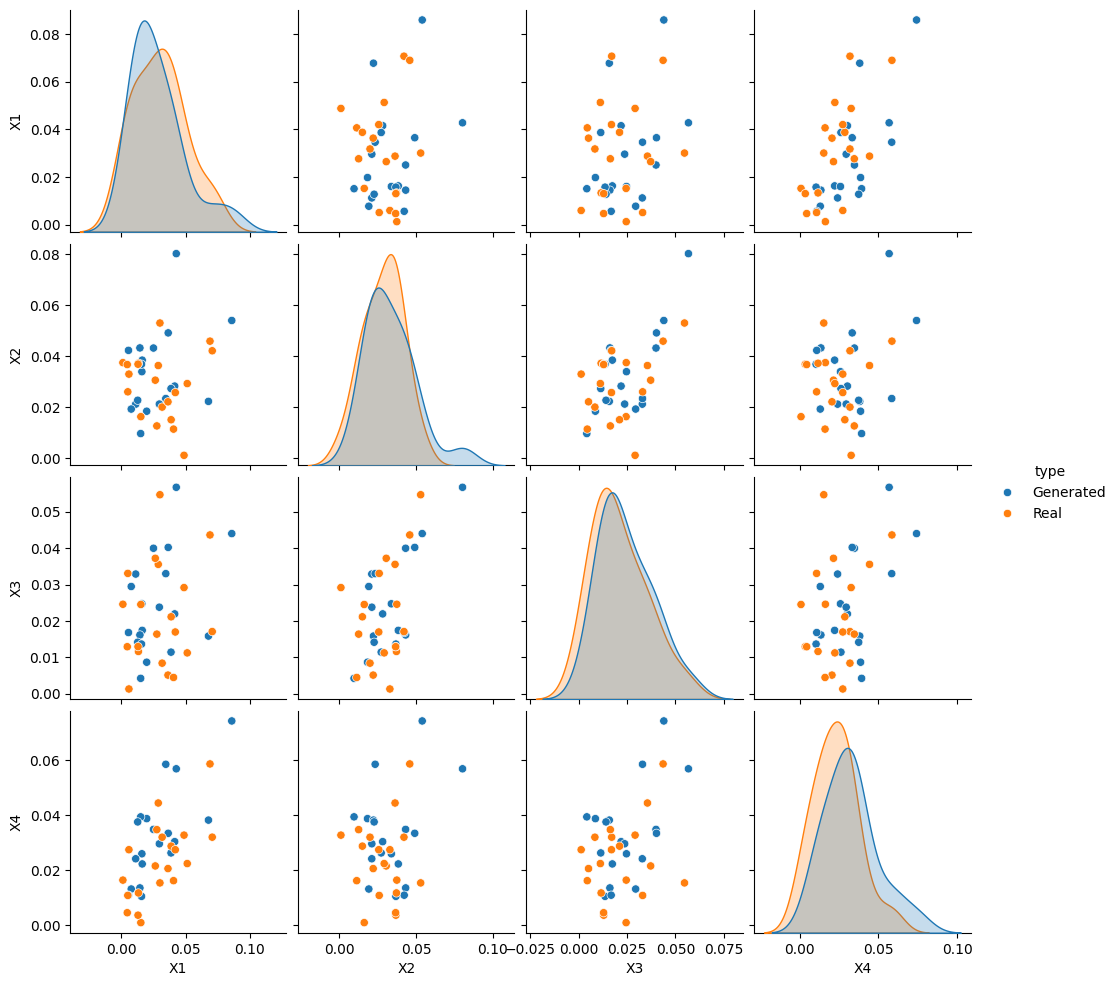

In [51]:
grid_plot(data_edm, test_data, quantile=0.95)
grid_plot(data_wgan, test_data, quantile=0.95)

Despite the metrics stating otherwise, it appears that W-GAN better captured the tails of the distribution.

### Conclusion

The EDM model shows a better performance according to the metrics and is consirably faster to train.
The W-GAN model, on the other hand, is consirably slower and has a slightly worse performance in terms of the two metrics we considered, but seems to capture better the behaviour of the extreme values of the distribution.

Given the goal of the project and more computational power, we suppose it would be worth working more on tuning W-GAN, ensuring a more accurate representation of extreme financial loss events (and, possibly, we a more extensive grid search for tuning, which could perhaps fill the gap in metrics performance). 

If instead the use case requires to train the model frequently, we would recommend EDM for a good tradeoff in performance and cost.